In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# **Semantic Segmentation with Traditional CV and Deep Learning Models**

**Import All Modules and Libraries**

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.cluster import KMeans
from skimage import morphology
from tensorflow.keras.utils import get_file
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import joblib

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

**Fuction - Load the Oxford-IIIT Pet Dataset**

In [9]:
# Load the Oxford-IIIT Pet Dataset
def load_oxford_pet_dataset(image_size=(128, 128)):
    # Download the dataset
    #dataset_url = "/content/drive/MyDrive/Colab Notebooks/SEM03-Assignments/Computer Vision/Project/images/"
    #annotations_url = "/content/drive/MyDrive/Colab Notebooks/SEM03-Assignments/Computer Vision/Project/annotations"

    # image_path = get_file("images.tar.gz", dataset_url, untar=True)
    # annotation_path = get_file("annotations.tar.gz", annotations_url, untar=True)

    image_path = "/content/drive/MyDrive/Colab Notebooks/SEM03-Assignments/Computer Vision/Project/"
    annotation_path = "/content/drive/MyDrive/Colab Notebooks/SEM03-Assignments/Computer Vision/Project/"

    image_dir = os.path.join(os.path.dirname(image_path), "images")
    mask_dir = os.path.join(os.path.dirname(annotation_path), "annotations/trimaps")

    # Get list of image and mask files
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])
    mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('.png')])

    # Get list of image and mask files, excluding hidden files (starting with '.')
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg') and not f.startswith('.')])
    mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('.png') and not f.startswith('.')])

    # Debugging: Print the first few file names to verify
    print(f"First 5 image files: {image_files[:5]}")
    print(f"First 5 mask files: {mask_files[:5]}")
    print(f"Total images: {len(image_files)}, Total masks: {len(mask_files)}")

    images = []
    masks = []

    # Pair images and masks by matching base names (without extensions)
    for img_file in image_files:
        base_name = os.path.splitext(img_file)[0]  # e.g., "Abyssinian_1"
        mask_file = base_name + ".png"  # Expected mask file name

        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)

        # Load image
        img = cv2.imread(img_path)
        if img is None:
            print(f"Failed to load image: {img_path}")
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, image_size)

        # Load mask
        if not os.path.exists(mask_path):
            print(f"Mask not found for image {img_file}: {mask_path}")
            continue
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            print(f"Failed to load mask: {mask_path}")
            continue

        mask = cv2.resize(mask, image_size, interpolation=cv2.INTER_NEAREST)

        # Convert mask to binary (0: background, 1: pet)
        mask = np.where(mask == 1, 1, 0)  # 1 for pet, 0 for background

        images.append(img)
        masks.append(mask)

    if not images:
        raise ValueError("No valid images or masks were loaded from the dataset.")

    images = np.array(images)
    masks = np.array(masks)

    print(f"Loaded {len(images)} valid image-mask pairs.")
    return images, masks

**Fuction - Visualize Results**

In [10]:
# Visualize Results
def plot_results(image, mask, pred, title="Segmentation Results"):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(image)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth Mask")
    plt.imshow(mask, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(pred, cmap='gray')
    plt.axis('off')

    plt.suptitle(title)
    plt.show()

**Fuction - Intersection over Union (IoU) Metric**

In [11]:
# Intersection over Union (IoU) Metric
def iou_metric(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return intersection / (union + 1e-6)

# Part 1: Traditional Computer Vision Techniques on the Oxford-IIIT Pet Dataset.

**Fuction - Traditional CV Segmentation using K-Means Clustering**

In [23]:
# 4. Traditional CV Segmentation using K-Means Clustering
def traditional_cv_segmentation(image, k=5):
    # Convert image to float32 for K-Means
    img = image.astype(np.float32)

    # Reshape image to a 2D array of pixels (height * width, channels)
    pixel_values = img.reshape((-1, 3))

    # Apply K-Means clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pixel_values)
    labels = kmeans.predict(pixel_values)

    # Reshape labels back to image dimensions
    segmented = labels.reshape(img.shape[:2])

    # Assume the cluster with the largest area is the background (common in pet images)
    unique, counts = np.unique(segmented, return_counts=True)
    background_cluster = unique[np.argmax(counts)]

    # Create binary mask (1 for pet, 0 for background)
    mask = np.where(segmented != background_cluster, 1, 0)

    # Refine mask using morphological operations
    mask = morphology.binary_closing(mask, morphology.disk(5))  # Close small gaps
    mask = morphology.binary_opening(mask, morphology.disk(3))  # Remove small noise

    MODEL_PATH = "/content/drive/MyDrive/Colab Notebooks/SEM03-Assignments/Computer Vision/Project/kmeans_model.joblib"
    joblib.dump(kmeans, MODEL_PATH)  # Save the model
    # print(f"Model saved at {MODEL_PATH}")

    return mask

**Fuction - Main Function to Run the K-Means Clustering Pipeline**

Loading dataset...
First 5 image files: ['Abyssinian_1.jpg', 'Abyssinian_10.jpg', 'Abyssinian_100.jpg', 'Abyssinian_101.jpg', 'Abyssinian_102.jpg']
First 5 mask files: ['Abyssinian_1.png', 'Abyssinian_10.png', 'Abyssinian_100.png', 'Abyssinian_101.png', 'Abyssinian_102.png']
Total images: 7400, Total masks: 7425
Failed to load image: /content/drive/MyDrive/Colab Notebooks/SEM03-Assignments/Computer Vision/Project/images/Abyssinian_34.jpg
Failed to load image: /content/drive/MyDrive/Colab Notebooks/SEM03-Assignments/Computer Vision/Project/images/Egyptian_Mau_139.jpg
Failed to load image: /content/drive/MyDrive/Colab Notebooks/SEM03-Assignments/Computer Vision/Project/images/Egyptian_Mau_145.jpg
Failed to load image: /content/drive/MyDrive/Colab Notebooks/SEM03-Assignments/Computer Vision/Project/images/Egyptian_Mau_167.jpg
Failed to load image: /content/drive/MyDrive/Colab Notebooks/SEM03-Assignments/Computer Vision/Project/images/Egyptian_Mau_177.jpg
Failed to load image: /content/dri

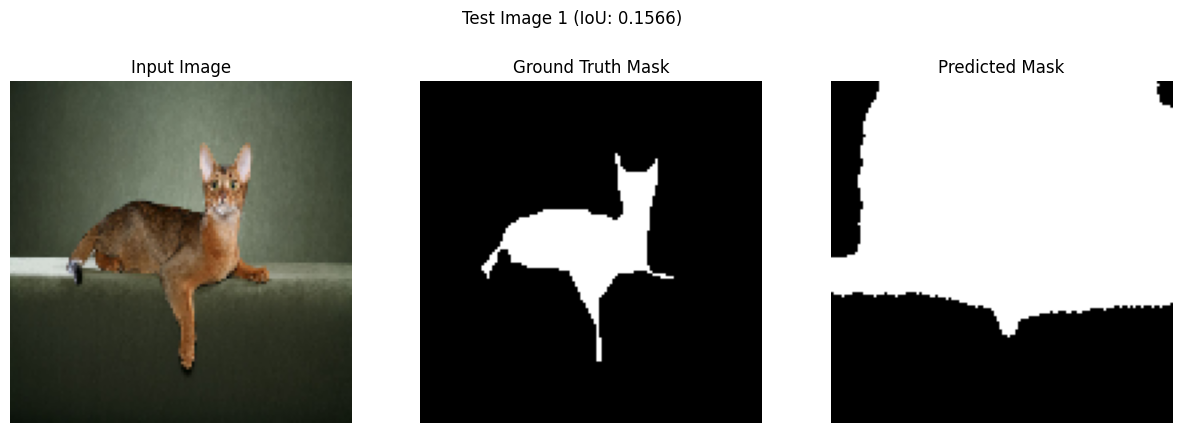

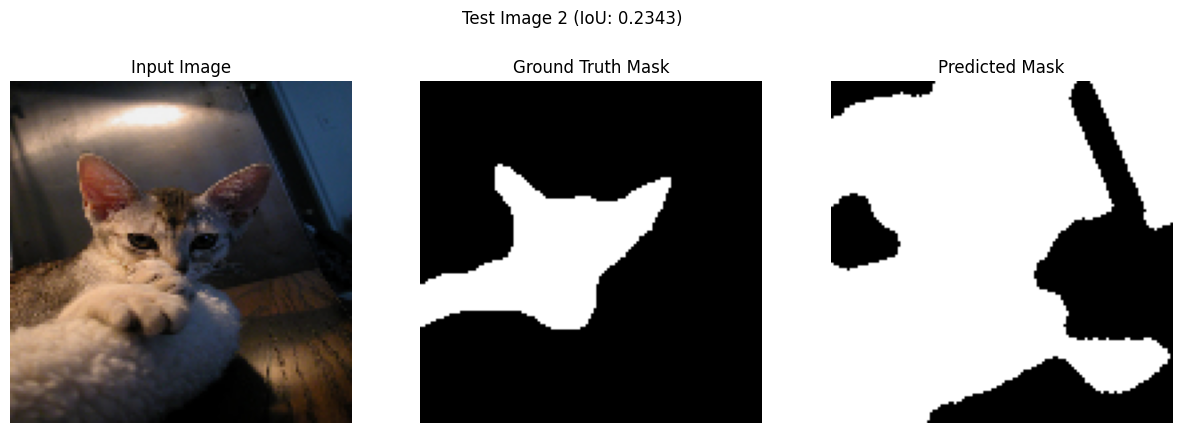

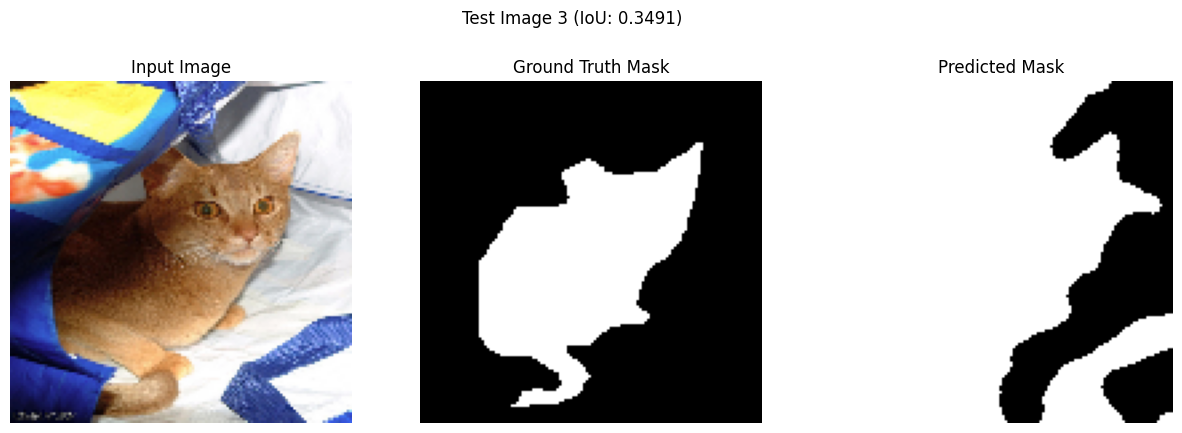

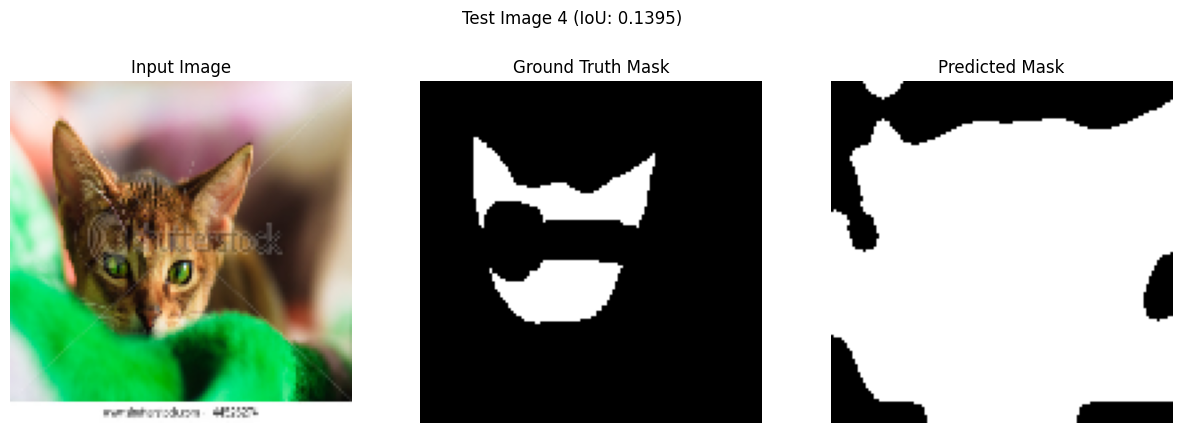

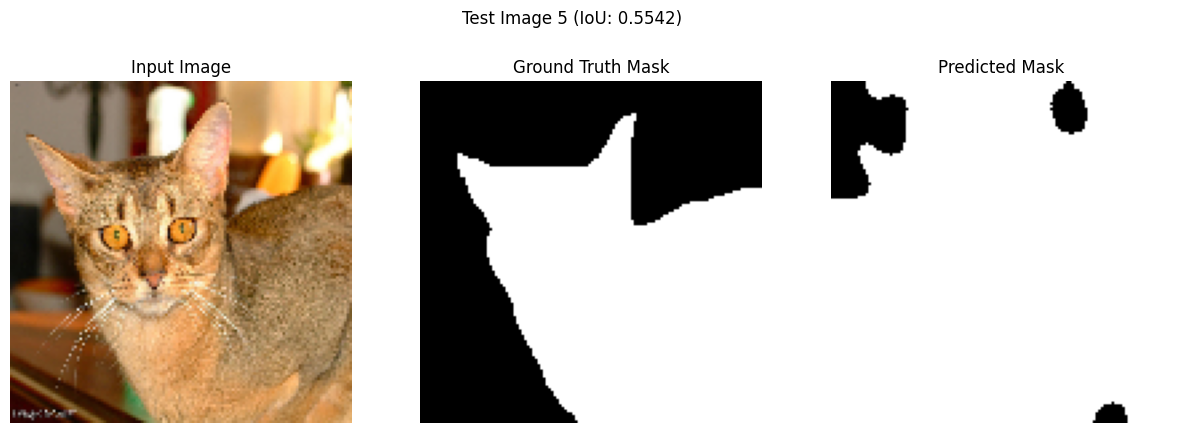

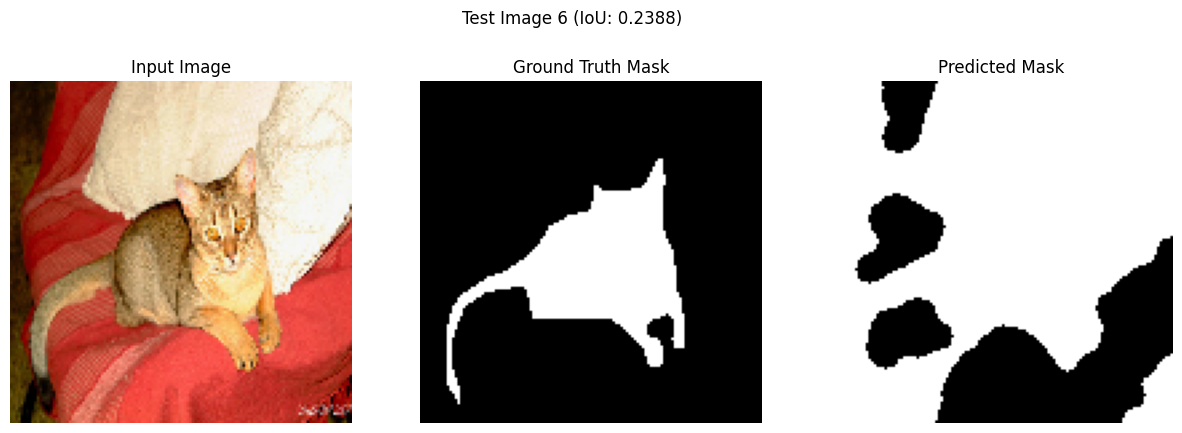

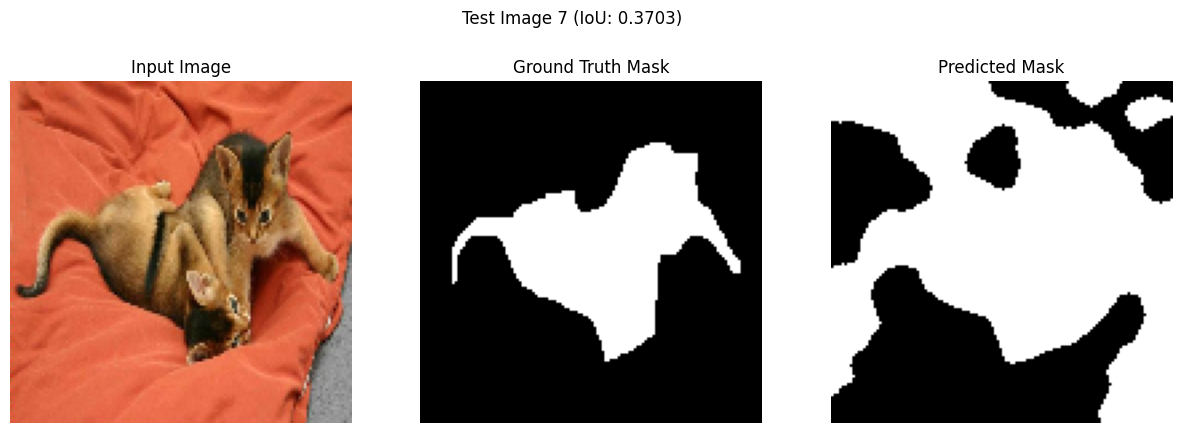

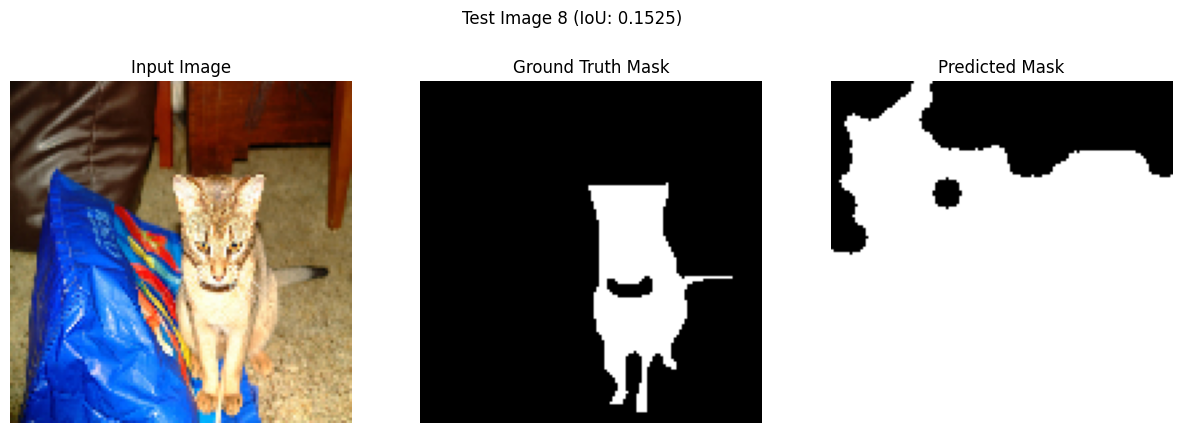

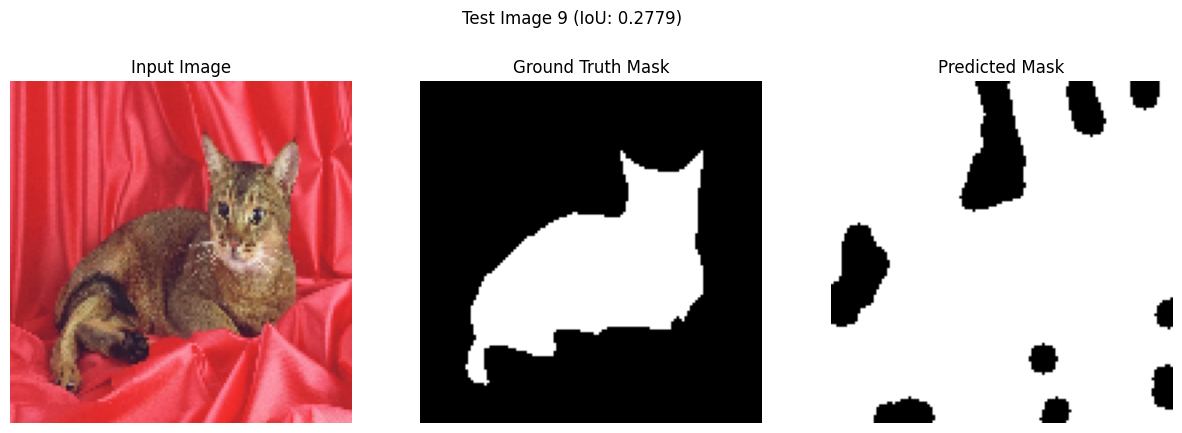

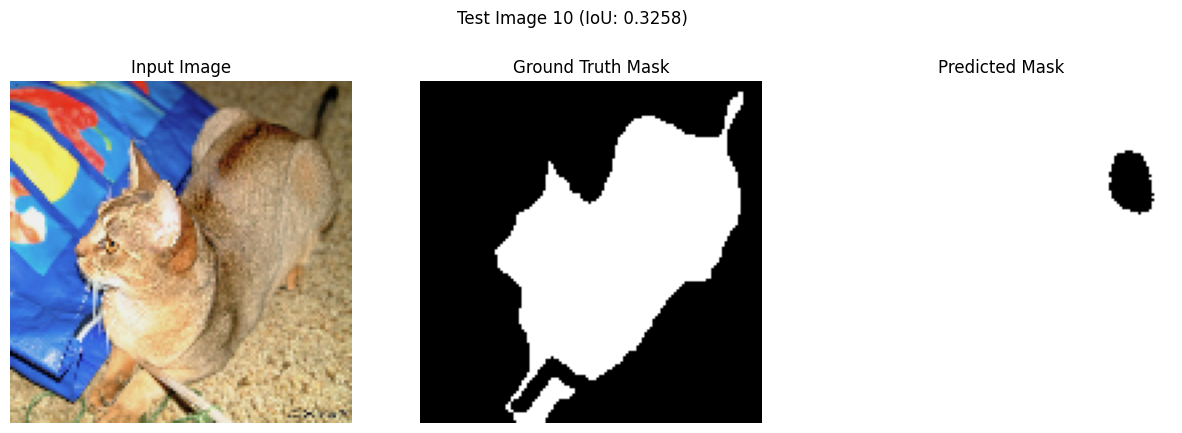

completed traditional CV segmentation...
Average IoU on 7380 test images: 0.3317


In [24]:
# Main Function to Run the K-Means Clustering Pipeline
def main():
    # Load dataset
    print("Loading dataset...")
    try:
        images, masks = load_oxford_pet_dataset(image_size=(128, 128))
    except ValueError as e:
        print(f"Error: {e}")
        return

    # Select a subset of images for testing (e.g., first 10 images)
    num_test_images = 7380
    test_images = images[:num_test_images]
    test_masks = masks[:num_test_images]

    # Process each test image
    iou_scores = []
    print("Performing traditional CV segmentation...")
    for i in range(num_test_images):
        # Perform segmentation
        pred_mask = traditional_cv_segmentation(test_images[i])

        # Calculate IoU
        iou = iou_metric(test_masks[i], pred_mask)
        iou_scores.append(iou)

        # Visualize results for the first 10 images
        if i < 10:
            plot_results(test_images[i], test_masks[i], pred_mask, title=f"Test Image {i+1} (IoU: {iou:.4f})")

    print("completed traditional CV segmentation...")
    # Report average IoU
    avg_iou = np.mean(iou_scores)
    print(f"Average IoU on {num_test_images} test images: {avg_iou:.4f}")

if __name__ == "__main__":
    main()

**Fuction - Traditional CV Segmentation using GrabCut**

In [25]:
# 4. Traditional CV Segmentation using GrabCut
def grabcut_segmentation(image):
    # Convert image to BGR (required by OpenCV's GrabCut)
    img_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    # Initialize mask, background, and foreground models for GrabCut
    mask = np.zeros(img_bgr.shape[:2], np.uint8)
    bgd_model = np.zeros((1, 65), np.float64)
    fgd_model = np.zeros((1, 65), np.float64)

    # Define a rectangle around the central region (assumes pet is roughly centered)
    height, width = img_bgr.shape[:2]
    rect = (10, 10, width - 20, height - 20)  # (x, y, width, height)

    # Run GrabCut
    cv2.grabCut(img_bgr, mask, rect, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_RECT)

    # Create binary mask: 0/2 (background) -> 0, 1/3 (foreground) -> 1
    pred_mask = np.where((mask == 2) | (mask == 0), 0, 1).astype(np.uint8)

    # Optional: Morphological operations to refine
    pred_mask = cv2.morphologyEx(pred_mask, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8))
    pred_mask = cv2.morphologyEx(pred_mask, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8))

    MODEL_PATH = "/content/drive/MyDrive/Colab Notebooks/SEM03-Assignments/Computer Vision/Project/grabCut_model.joblib"
    joblib.dump(pred_mask, MODEL_PATH)  # Save the model
    # print(f"Model saved at {MODEL_PATH}")

    return pred_mask

**Fuction - Main Function to Run the GrabCut Pipeline**

Loading dataset...
First 5 image files: ['Abyssinian_1.jpg', 'Abyssinian_10.jpg', 'Abyssinian_100.jpg', 'Abyssinian_101.jpg', 'Abyssinian_102.jpg']
First 5 mask files: ['Abyssinian_1.png', 'Abyssinian_10.png', 'Abyssinian_100.png', 'Abyssinian_101.png', 'Abyssinian_102.png']
Total images: 7400, Total masks: 7425
Failed to load image: /content/drive/MyDrive/Colab Notebooks/SEM03-Assignments/Computer Vision/Project/images/Abyssinian_34.jpg
Failed to load image: /content/drive/MyDrive/Colab Notebooks/SEM03-Assignments/Computer Vision/Project/images/Egyptian_Mau_139.jpg
Failed to load image: /content/drive/MyDrive/Colab Notebooks/SEM03-Assignments/Computer Vision/Project/images/Egyptian_Mau_145.jpg
Failed to load image: /content/drive/MyDrive/Colab Notebooks/SEM03-Assignments/Computer Vision/Project/images/Egyptian_Mau_167.jpg
Failed to load image: /content/drive/MyDrive/Colab Notebooks/SEM03-Assignments/Computer Vision/Project/images/Egyptian_Mau_177.jpg
Failed to load image: /content/dri

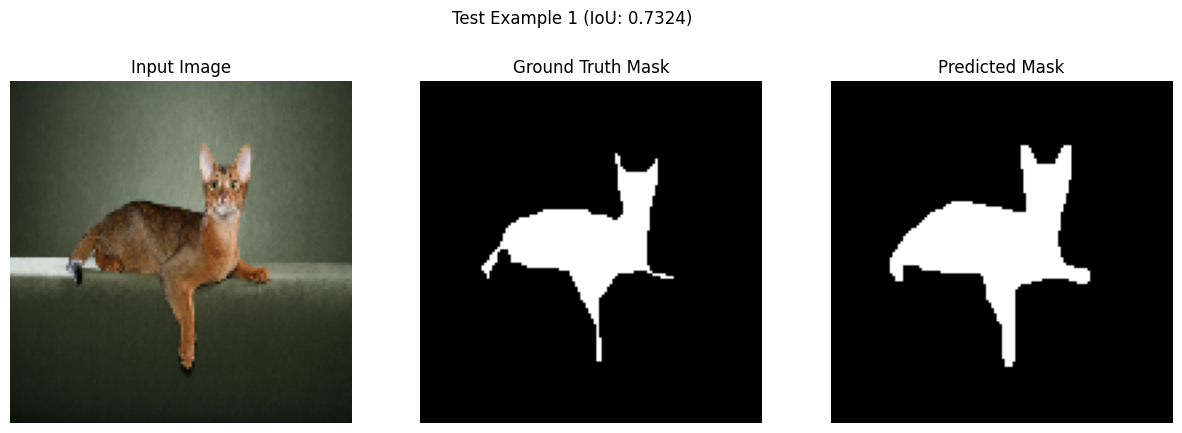

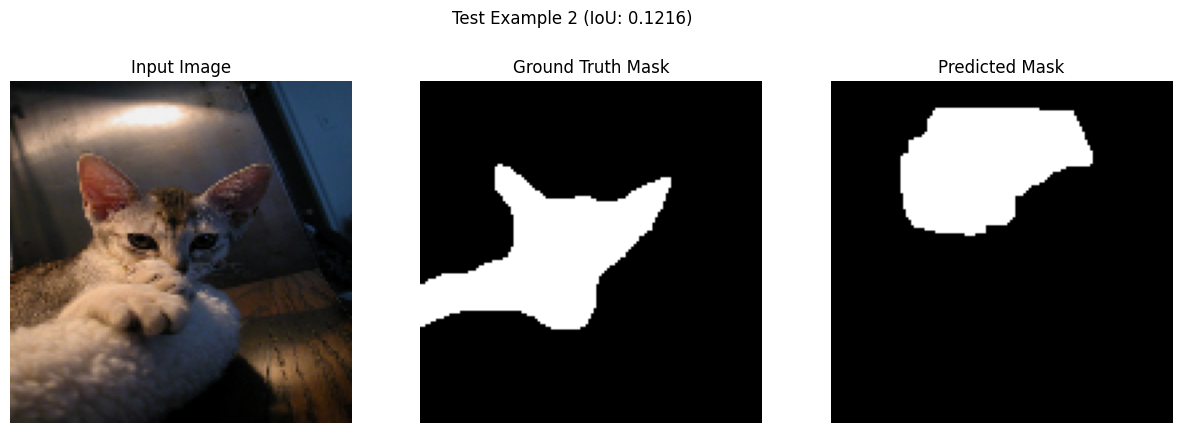

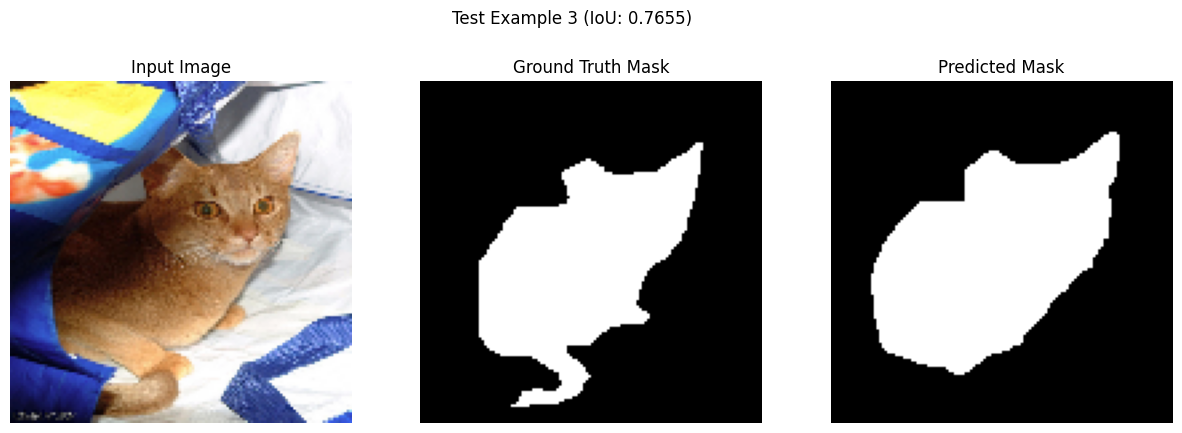

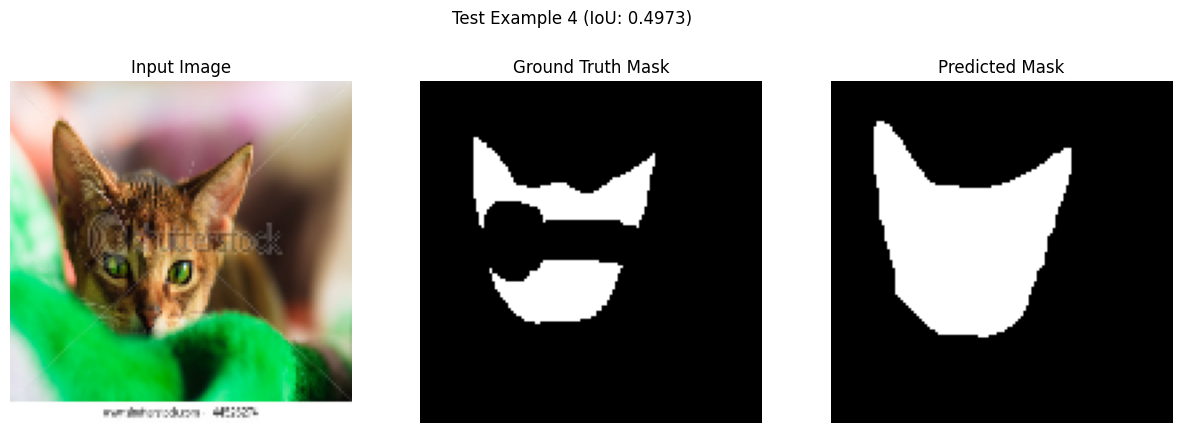

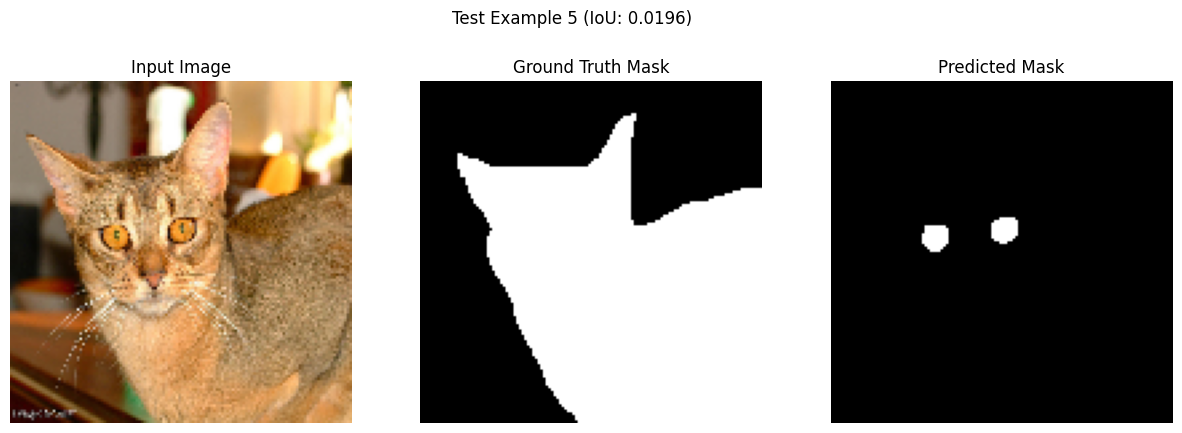

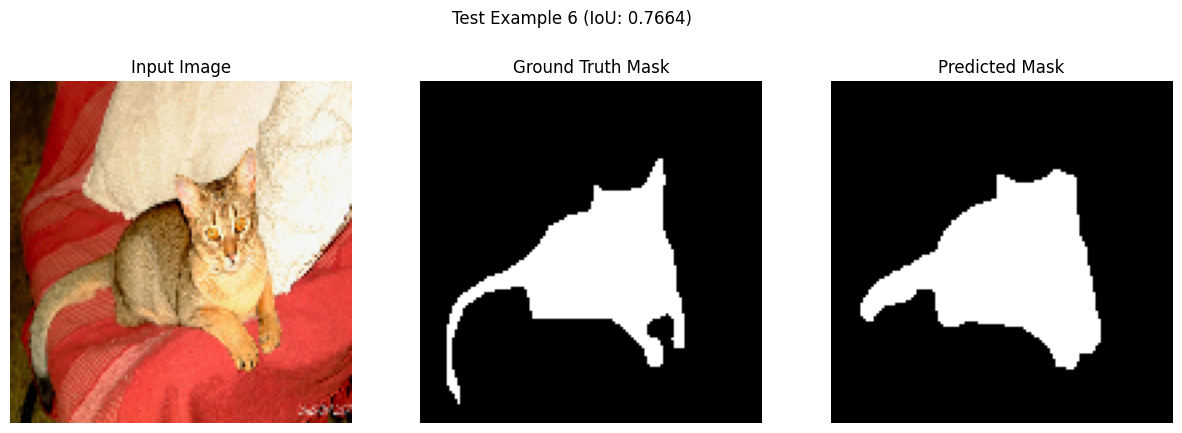

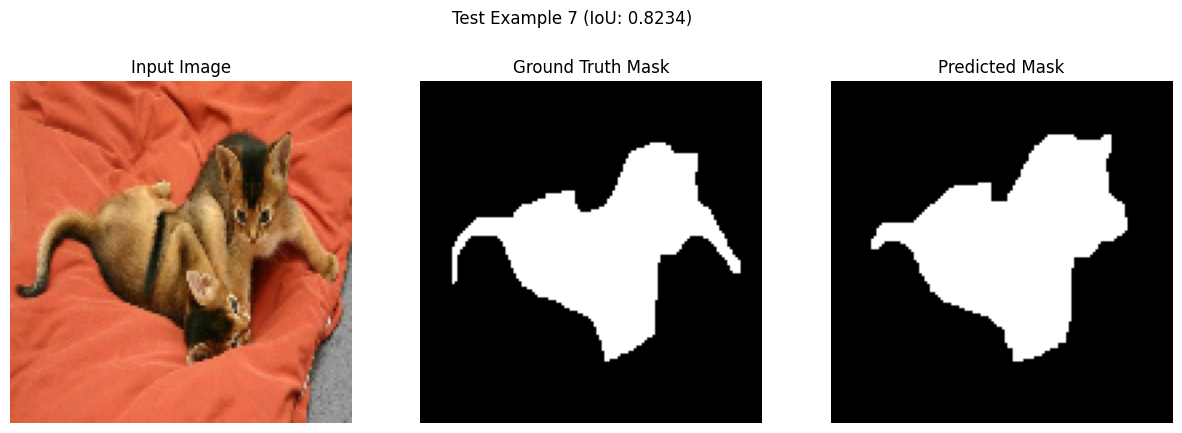

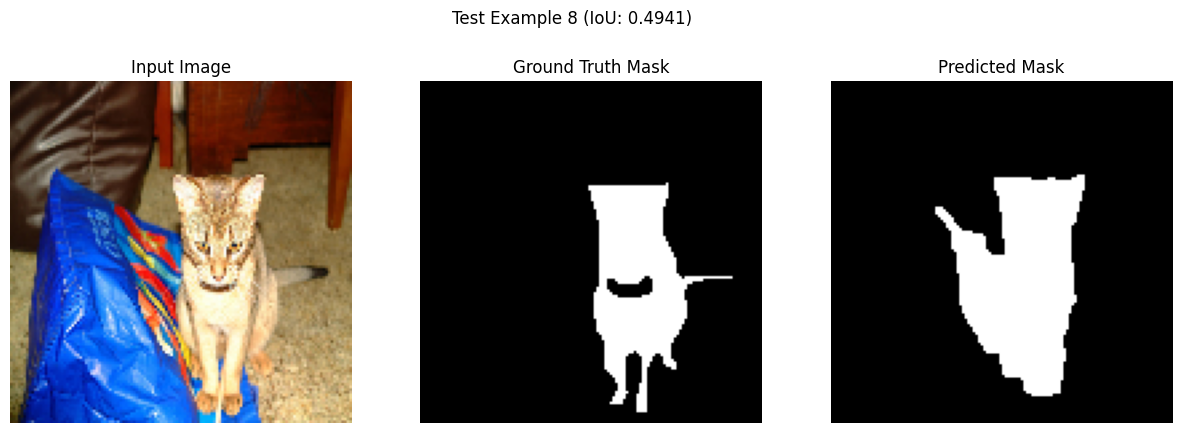

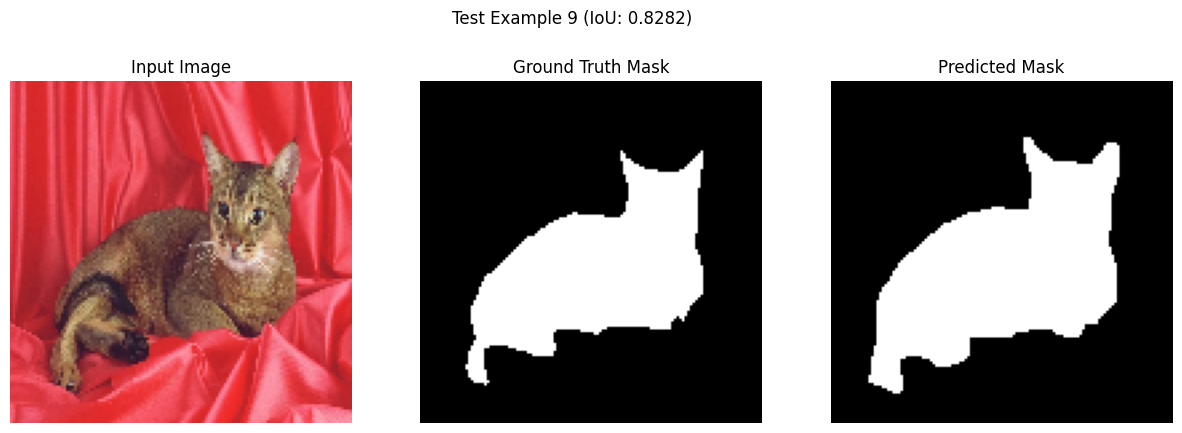

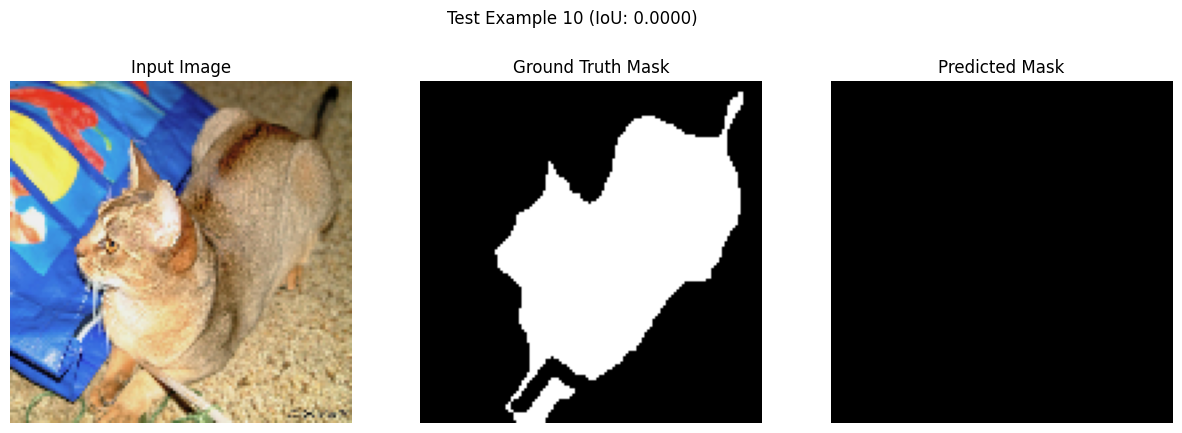

Average IoU on 7380 test images: 0.3863


In [26]:
# Main Function to Run the Pipeline
def main():
    print("Loading dataset...")
    try:
        images, masks = load_oxford_pet_dataset(image_size=(128, 128))
    except ValueError as e:
        print(f"Error: {e}")
        return

    # Use a smaller subset for testing due to computational cost
    num_test_images = min(7380, len(images))
    test_images = images[:num_test_images]
    test_masks = masks[:num_test_images]

    iou_scores = []
    print("Performing GrabCut segmentation...")
    for i in range(num_test_images):
        pred_mask = grabcut_segmentation(test_images[i])
        iou = iou_metric(test_masks[i], pred_mask)
        iou_scores.append(iou)
        if i < 10:
            plot_results(test_images[i], test_masks[i], pred_mask, title=f"Test Example {i+1} (IoU: {iou:.4f})")

    avg_iou = np.mean(iou_scores)
    print(f"Average IoU on {num_test_images} test images: {avg_iou:.4f}")

if __name__ == "__main__":
    main()

# Part 2: Deep Learning Models Approach with the U-Net on the Oxford-IIIT Pet Dataset.

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
import os
from tensorflow.keras.utils import get_file

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

In [2]:
# Force TensorFlow to run only on GPU
def force_gpu():
    # List all physical devices
    gpus = tf.config.list_physical_devices('GPU')
    if not gpus:
        raise RuntimeError("No GPU found. Cannot proceed with GPU-only execution.")

    # Restrict TensorFlow to only see GPU devices (hide CPU)
    tf.config.set_visible_devices(gpus, 'GPU')
    print(f"Visible devices restricted to GPUs: {gpus}")

    # Enable memory growth for each GPU
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

    # Verify that only GPUs are used
    logical_devices = tf.config.list_logical_devices('GPU')
    if not logical_devices:
        raise RuntimeError("Failed to configure GPU-only execution.")
    print(f"Logical GPU devices: {logical_devices}")

In [3]:
# 1. Load and Preprocess the Oxford-IIIT Pet Dataset
def load_oxford_pet_dataset(image_size=(128, 128), max_samples=None):
    # dataset_url = "http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz"
    # annotations_url = "http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz"

    # image_path = get_file("images.tar.gz", dataset_url, untar=True)
    # annotation_path = get_file("annotations.tar.gz", annotations_url, untar=True)

    image_path = "/content/drive/MyDrive/Colab Notebooks/SEM03-Assignments/Computer Vision/Project/"
    annotation_path = "/content/drive/MyDrive/Colab Notebooks/SEM03-Assignments/Computer Vision/Project/"

    image_dir = os.path.join(os.path.dirname(image_path), "images")
    mask_dir = os.path.join(os.path.dirname(annotation_path), "annotations/trimaps")

    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg') and not f.startswith('.')])
    mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('.png') and not f.startswith('.')])

    if max_samples is not None:
        image_files = image_files[:max_samples]

    images = []
    masks = []

    for img_file in image_files:
        base_name = os.path.splitext(img_file)[0]
        mask_file = base_name + ".png"

        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)

        img = cv2.imread(img_path)
        if img is None:
            print(f"Failed to load image: {img_path}")
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, image_size)
        img = img / 255.0  # Normalize to [0, 1]

        if not os.path.exists(mask_path):
            print(f"Mask not found for image {img_file}: {mask_path}")
            continue
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            print(f"Failed to load mask: {mask_path}")
            continue

        mask = cv2.resize(mask, image_size, interpolation=cv2.INTER_NEAREST)
        mask = np.where(mask == 1, 1, 0).astype(np.float32)  # Binary mask as float32
        mask = np.expand_dims(mask, axis=-1)  # Add channel dimension here

        images.append(img)
        masks.append(mask)

    images = np.array(images)
    masks = np.array(masks)

    print(f"Loaded {len(images)} valid image-mask pairs.")
    print(f"Images shape: {images.shape}, Masks shape: {masks.shape}")
    return images, masks

**Fuction - Define the U-Net Model**

In [4]:
# 2. Define the U-Net Model
def unet_model(input_shape=(128, 128, 3), num_classes=1):
    inputs = layers.Input(input_shape)

    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(c9)

    return models.Model(inputs, outputs)

**Fuction - Define Dice Loss.**

In [5]:
# 3. Define Dice Loss
def dice_loss(y_true, y_pred):
    smooth = 1e-6
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

In [6]:
# 4. Intersection over Union (IoU) Metric
def iou_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return intersection / (union + 1e-6)

# 5. IoU Calculation for Individual Test Examples (NumPy-based)
def calculate_iou(y_true, y_pred):
    y_true = y_true.astype(np.float32)
    y_pred = (y_pred > 0.5).astype(np.float32)  # Binarize prediction
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return intersection / (union + 1e-6)

In [7]:
# 6. Visualize Results with IoU
def plot_results(image, mask, pred, iou, example_num):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(image)
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.title("Ground Truth Mask")
    plt.imshow(mask.squeeze(), cmap='gray')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(pred.squeeze(), cmap='gray')
    plt.axis('off')
    plt.suptitle(f"Test Example {example_num} (IoU: {iou:.4f})")
    plt.show()

**Fuction - Main Function to Run the U-Net Model Pipeline**

Visible devices restricted to GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Logical GPU devices: [LogicalDevice(name='/device:GPU:0', device_type='GPU')]
Loading dataset...
Failed to load image: /content/drive/MyDrive/Colab Notebooks/SEM03-Assignments/Computer Vision/Project/images/Abyssinian_34.jpg
Failed to load image: /content/drive/MyDrive/Colab Notebooks/SEM03-Assignments/Computer Vision/Project/images/Egyptian_Mau_139.jpg
Failed to load image: /content/drive/MyDrive/Colab Notebooks/SEM03-Assignments/Computer Vision/Project/images/Egyptian_Mau_145.jpg
Failed to load image: /content/drive/MyDrive/Colab Notebooks/SEM03-Assignments/Computer Vision/Project/images/Egyptian_Mau_167.jpg
Failed to load image: /content/drive/MyDrive/Colab Notebooks/SEM03-Assignments/Computer Vision/Project/images/Egyptian_Mau_177.jpg
Failed to load image: /content/drive/MyDrive/Colab Notebooks/SEM03-Assignments/Computer Vision/Project/images/Egyptian_Mau_191.jpg
Loaded 3994 valid

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 8, 8, 512)      │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 8, 8, 1024)     │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 8, 8, 1024)     │      9,438,208 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 16, 16, 512)    │      2,097,664 │ conv2d_9[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 16, 16, 1024)   │              0 │ conv2d_transpose[0][0… │
│                      

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

Training model...
Epoch 1/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 116s 223ms/step - iou_metric: 0.3053 - loss: 0.5394 - val_iou_metric: 0.2999 - val_loss: 0.5425
Epoch 2/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 90s 144ms/step - iou_metric: 0.3053 - loss: 0.5361 - val_iou_metric: 0.2999 - val_loss: 0.5425
Epoch 3/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 83s 146ms/step - iou_metric: 0.3053 - loss: 0.5361 - val_iou_metric: 0.2999 - val_loss: 0.5425
Epoch 4/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 58s 145ms/step - iou_metric: 0.3053 - loss: 0.5361 - val_iou_metric: 0.2999 - val_loss: 0.5425
Epoch 5/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 82s 144ms/step - iou_metric: 0.3053 - loss: 0.5361 - val_iou_metric: 0.2999 - val_loss: 0.5425

Average Training IoU across 5 epochs: 0.3066
Average Validation IoU across 5 epochs: 0.2999
Evaluating model...
25/25 ━━━━━━━━━━━━━━━━━━━━ 31s 703ms/step - iou_metric: 0.2929 - loss: 0.5480
Test IoU: 0.2998
Visualizing results...
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step
Test Example 1 IoU: 0.1624


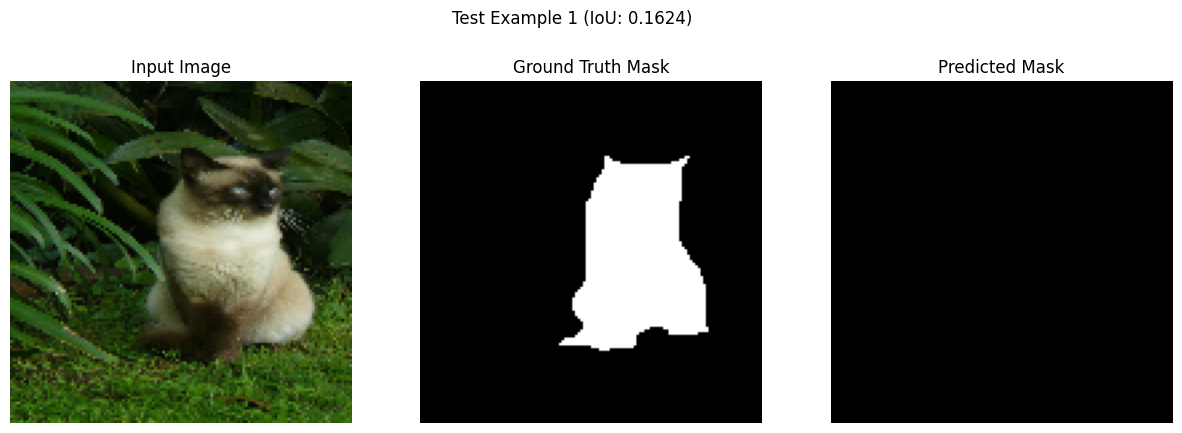

Test Example 2 IoU: 0.1913


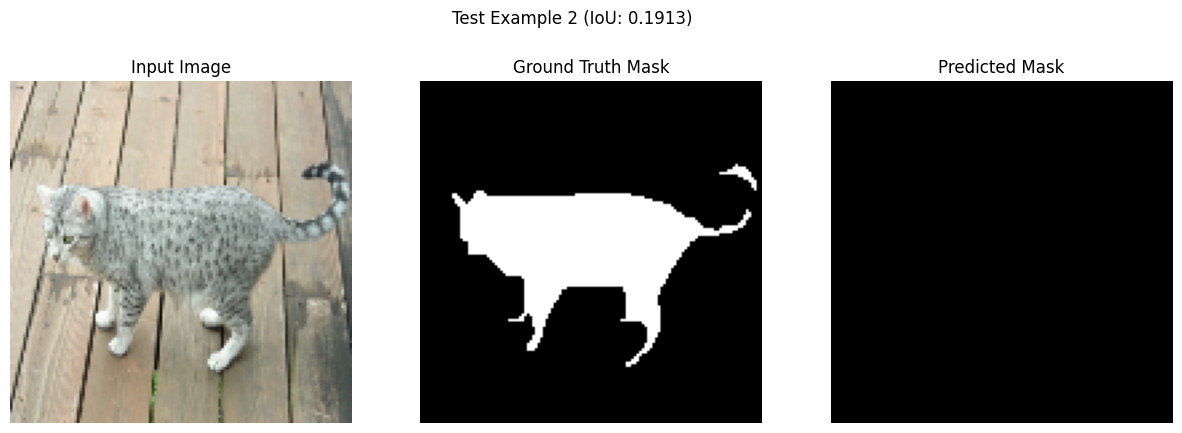

Test Example 3 IoU: 0.5173


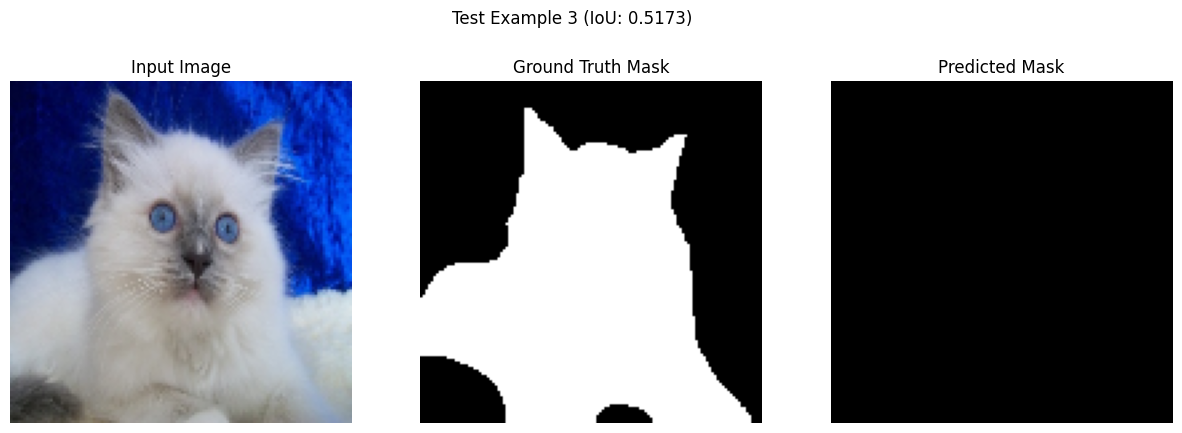

Test Example 4 IoU: 0.1979


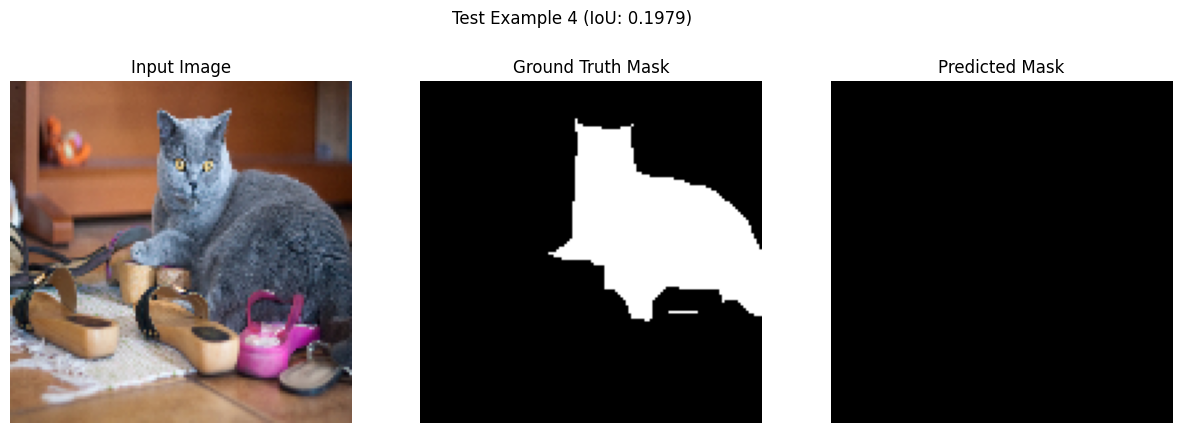

Test Example 5 IoU: 0.1053


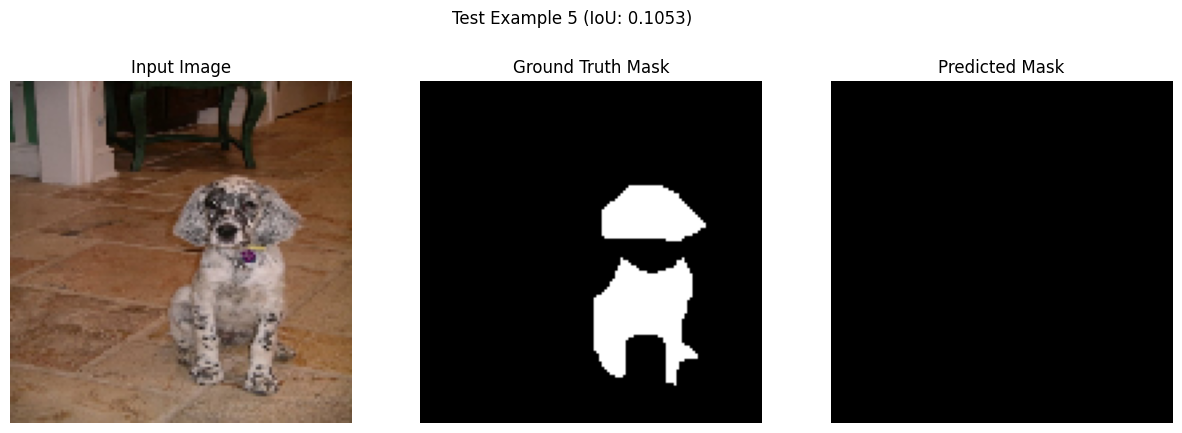

Test Example 6 IoU: 0.3868


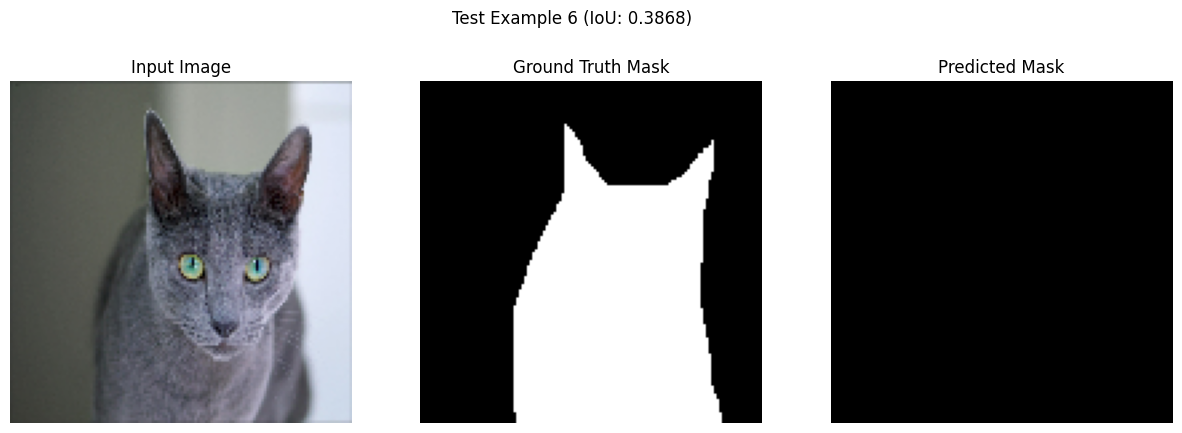

Test Example 7 IoU: 0.0474


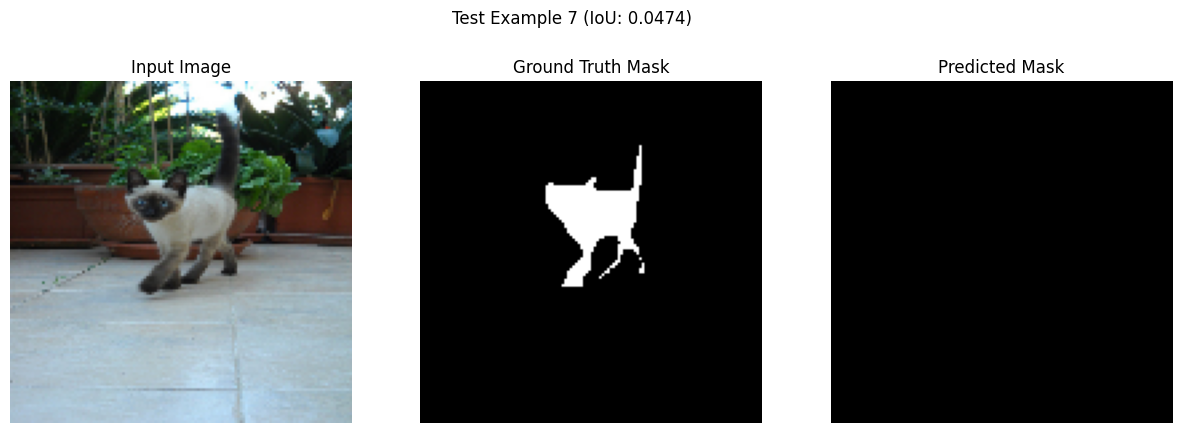

Test Example 8 IoU: 0.7178


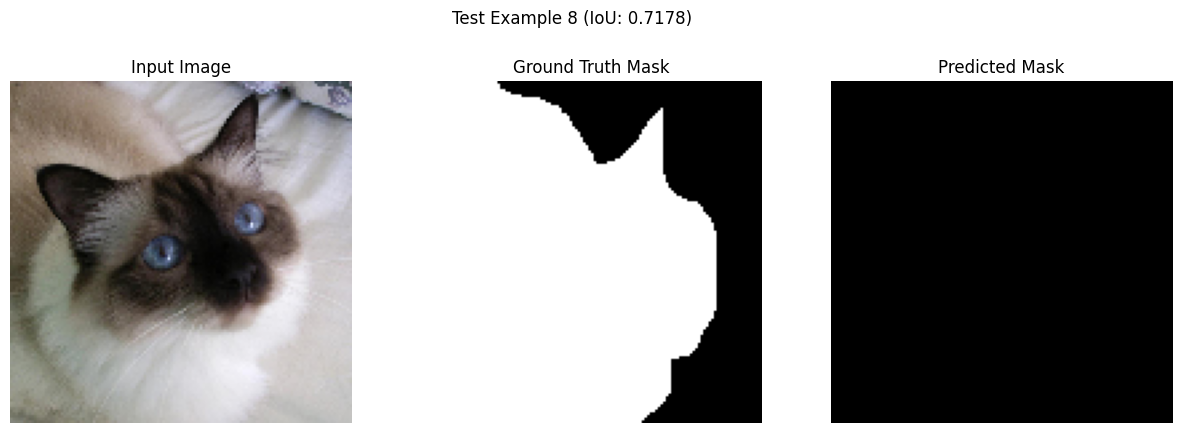

Test Example 9 IoU: 0.2167


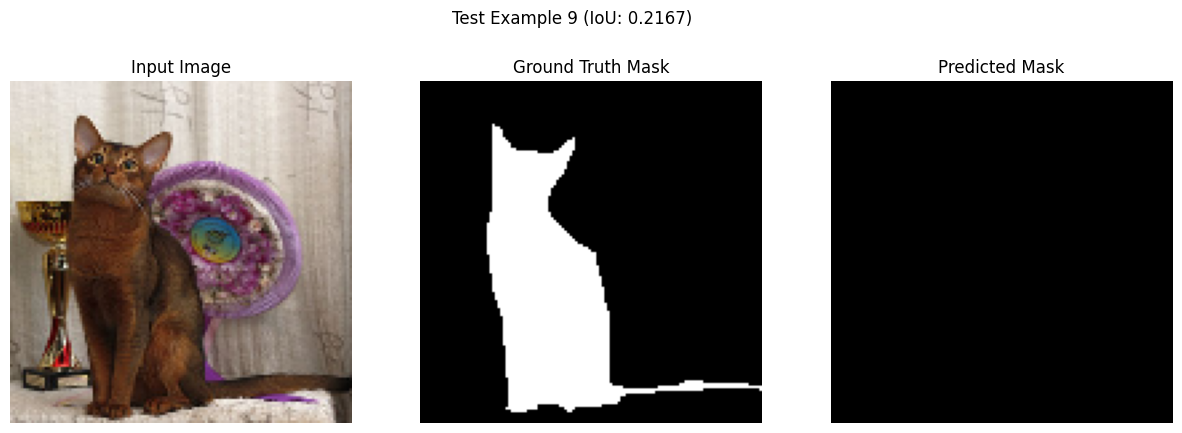

Test Example 10 IoU: 0.3231


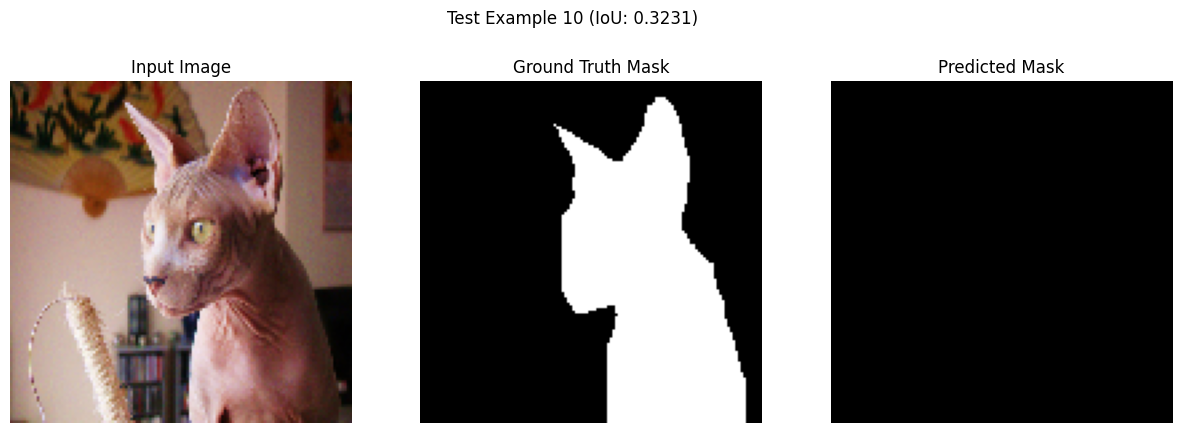

Model saved as 'unet_model.h5'


In [8]:
# 6. Main Function
def main():

  # Force GPU-only execution
    try:
        force_gpu()
    except RuntimeError as e:
        print(f"Error: {e}")
        return

    print("Loading dataset...")
    images, masks = load_oxford_pet_dataset(image_size=(128, 128), max_samples=4000)

    # Verify shapes before splitting
    print(f"Images shape before split: {images.shape}")
    print(f"Masks shape before split: {masks.shape}")

    X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=42)

    # Verify shapes after splitting
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

    model = unet_model(input_shape=(128, 128, 3), num_classes=1)
    model.compile(optimizer='adam', loss=dice_loss, metrics=[iou_metric])

    model.summary()

    print("Training model...")
    try:
        history = model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            epochs=5,
            batch_size=8,  # Adjusted for GPU (e.g., T4 with 15GB)
            verbose=1
        )

        # Calculate and print average IoU from training history
        train_iou = history.history['iou_metric']
        val_iou = history.history['val_iou_metric']
        avg_train_iou = np.mean(train_iou)
        avg_val_iou = np.mean(val_iou)
        print(f"\nAverage Training IoU across {len(train_iou)} epochs: {avg_train_iou:.4f}")
        print(f"Average Validation IoU across {len(val_iou)} epochs: {avg_val_iou:.4f}")

    except Exception as e:
        print(f"Training failed with error: {e}")
        return

    print("Evaluating model...")
    test_loss, test_iou = model.evaluate(X_test, y_test)
    print(f"Test IoU: {test_iou:.4f}")

    print("Visualizing results...")
    predictions = model.predict(X_test)
    for i in range(10):
        pred = predictions[i]
        iou = calculate_iou(y_test[i], pred)  # Calculate IoU for this example
        print(f"Test Example {i+1} IoU: {iou:.4f}")
        plot_results(X_test[i], y_test[i], pred, iou, example_num=i+1)

    # Save the model
    model.save("/content/drive/MyDrive/Colab Notebooks/SEM03-Assignments/Computer Vision/Project/unet_model.h5")
    print("Model saved as 'unet_model.h5'")

if __name__ == "__main__":
    main()